<a href="https://colab.research.google.com/github/plus2net/numpy/blob/main/numpy_15_ml_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://www.plus2net.com/images/top2.jpg)        Read more on [Machine Learning Pipelines  ](https://www.plus2net.com/python/numpy-ml-pipelines.php) | [ Numpy ](https://www.plus2net.com/python/numpy.php)

Accuracy: 0.5


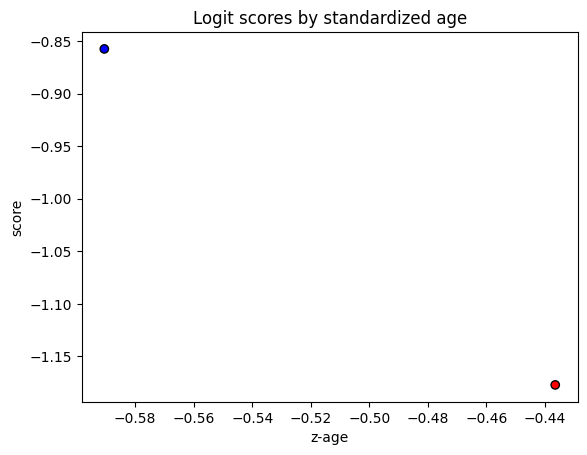

In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 1) Load with Pandas
df = pd.DataFrame({
    'age':[22,35,58,45,26,33,52,41],
    'income':[35,62,120,85,40,59,110,77],
    'city':['A','B','A','C','B','A','C','B'],
    'bought':[0,1,1,1,0,0,1,0]
})

# 2) Minimal encoding with NumPy (one-hot for 'city')
cities = pd.Categorical(df['city'])
X_city = pd.get_dummies(cities).to_numpy()        # (n, k)

# 3) Numeric block as NumPy
X_num = df[['age','income']].to_numpy(dtype='float64')

# 4) Concatenate features
X = np.hstack([X_num, X_city])                    # (n, d)
y = df['bought'].to_numpy()

# 5) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

# 6) Standardize numeric columns (first 2 columns)
scaler = StandardScaler(with_mean=True, with_std=True)
X_tr[:, :2] = scaler.fit_transform(X_tr[:, :2])
X_te[:, :2] = scaler.transform(X_te[:, :2])

# 7) Fit a model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)
print('Accuracy:', clf.score(X_te, y_te))

# 8) Visualize decision scores vs. a feature
scores = clf.decision_function(X_te)
plt.scatter(X_te[:,0], scores, c=y_te, cmap='bwr', edgecolors='k')
plt.xlabel('z-age'); plt.ylabel('score'); plt.title('Logit scores by standardized age')
plt.show()

In [2]:
Z = df[['age','income']].to_numpy(dtype='float64')

# Feature crosses
cross = (Z[:,0] * Z[:,1])[:, None]  # (n,1)

# Binning (example): income deciles → one-hot
q = np.quantile(Z[:,1], np.linspace(0, 1, 11))
bin_idx = np.searchsorted(q, Z[:,1], side='right') - 1
bin_idx = np.clip(bin_idx, 0, 9)
onehot_bins = np.eye(10, dtype=int)[bin_idx]      # (n,10)

features = np.hstack([Z, cross, onehot_bins])     # final design matrix

In [3]:
X = np.random.randn(100, 5)
mu = X.mean(0, keepdims=True)
S = ((X - mu).T @ (X - mu)) / (X.shape[0]-1)  # covariance

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Example: build on the original df
numeric_cols = ['age','income']
categorical_cols = ['city']

pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipe = Pipeline([
    ('prep', pre),
    ('model', RandomForestClassifier(n_estimators=200, random_state=0))
])

pipe.fit(df[numeric_cols+categorical_cols], df['bought'])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=0))])

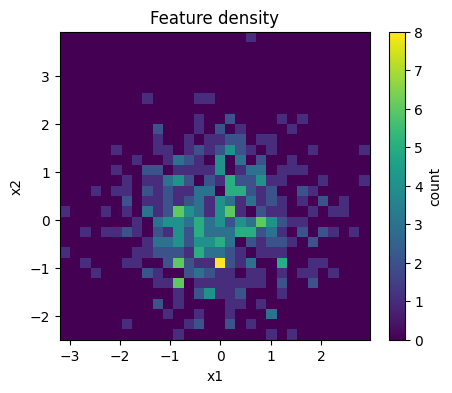

In [5]:
import matplotlib.pyplot as plt
X = np.random.randn(500, 2)
plt.figure(figsize=(5,4))
plt.hist2d(X[:,0], X[:,1], bins=30, cmap='viridis')
plt.colorbar(label='count'); plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Feature density')
plt.show()

In [6]:
X = df[['age','income']].to_numpy(float)
mask = ~np.isfinite(X)
col_means = np.nanmean(X, axis=0)
X[mask] = np.take(col_means, np.where(mask)[1])

AUC: 0.8307379349046016


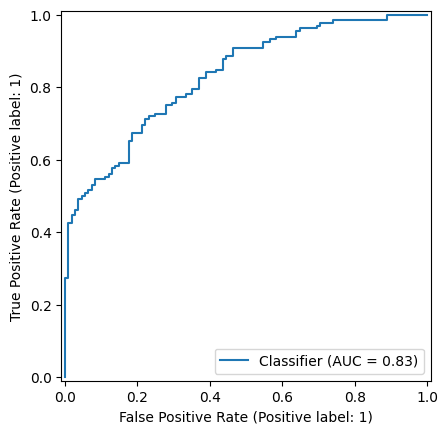

In [7]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Synthetic dataset
rng = np.random.default_rng(9)
n = 800
age = rng.normal(35, 8, n)
income = rng.normal(70, 20, n)
city = rng.choice(['A','B','C'], size=n, p=[0.4,0.4,0.2])

# True rule (hidden)
z = 0.03*(age-35) + 0.02*(income-70) + (city=='C')*0.5 + rng.normal(0, 0.5, n)
y = (z > 0.0).astype(int)

# Frame → NumPy
df = pd.DataFrame({'age':age, 'income':income, 'city':city, 'y':y})
X_num = df[['age','income']].to_numpy(float)
X_city = pd.get_dummies(df['city']).to_numpy()
X = np.hstack([X_num, X_city])
y = df['y'].to_numpy()

# Split, scale numeric
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler().fit(X_tr[:, :2])
X_tr[:, :2] = scaler.transform(X_tr[:, :2])
X_te[:, :2] = scaler.transform(X_te[:, :2])

# Train & evaluate
clf = LogisticRegression(max_iter=1000).fit(X_tr, y_tr)
proba = clf.predict_proba(X_te)[:,1]
print('AUC:', roc_auc_score(y_te, proba))

# Plot ROC
RocCurveDisplay.from_predictions(y_te, proba)
plt.show()

In [9]:
# 1) Build a NumPy-only one-hot encoder for an integer category array (0..k-1).
cats = np.array([0,2,1,2,0])
onehot = np.eye(cats.max()+1, dtype=int)[cats]

# 2) Write a function that z-scores each column of X using keepdims.
def zscore(X):
    mu = X.mean(0, keepdims=True)
    sd = X.std(0, keepdims=True)
    return (X - mu) / (sd + 1e-9)

# 3) Using train/test split, compare a baseline logistic regression with and without scaling.
X = df[['age','income']].to_numpy(float)
y = df['y'].to_numpy()

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Baseline Logistic Regression (without scaling)
clf_no_scale = LogisticRegression(max_iter=1000).fit(X_tr, y_tr)
score_no_scale = clf_no_scale.score(X_te, y_te)
print(f'Accuracy without scaling: {score_no_scale:.4f}')

# Logistic Regression with scaling
scaler = StandardScaler().fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

clf_scaled = LogisticRegression(max_iter=1000).fit(X_tr_scaled, y_tr)
score_scaled = clf_scaled.score(X_te_scaled, y_te)
print(f'Accuracy with scaling: {score_scaled:.4f}')

Accuracy without scaling: 0.7042
Accuracy with scaling: 0.7042
